# Deep Support Vector Data Description

From Ruff 2018. The architecture and hyperparameters values are directly taken from the paper as a first test.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# DRIVE
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.decision.reconstruction import binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Sun Jul 19 16:51:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import data

In [34]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

interest_digit = 0

# validation set
x_val, y_val_bin = x_train[-1000:], binarize_set(y_train[-1000:], interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit][:-1000], y_train[np.where(y_train[:-1000] == interest_digit)][:-1000]
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape, x_val.shape, y_val_bin.shape)

(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)


In [35]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
from uad.decision.deep_svdd import anomaly_score_from_predictions, is_anormal
from uad.diagnostic.metrics import binarize_set

def anomaly_score_from_predictions(model, predictions):
    """
    Compute the anomaly score from preidctions of model. Those predictions are considered
    to vectors
    # TODO: implement for matrix or 3-tensors predictions
    :param model: Model that has a CENTER attribute
    :param predictions: Model predictions
    :return:
    """
    if len(predictions.shape) > 1:  # batch of vectors along the first axis
        return tf.norm(model.CENTER - predictions, axis=-1) ** 2
    else:  # single vector, tf.norm parameter axis=None
        return tf.norm(model.CENTER - predictions) ** 2
    
    
def anomaly_score_from_images(model, images):
    """
    Compute the anomaly score output by a model from a single image or a batch of images
    :param model: Deep SVDD model that possedes a self.CENTRE attribute
    :param images: either single image or batch of images
    :param n_images_axis: (int) Number of axis of the images/batch of images. If a single image
    is a 3-tensor (tf default format: (x, y, channels)) input 3, if images are matrices (x, y)
    input 2.
    :return:
    """
    predictions = model.predict(images)
    return anomaly_score_from_predictions(model, predictions)


class DeepSVDD(Model):
    """
    Support Vector Data Description neural network. Trained on original data and learns a dense embedding while
    trained on the objective function.
    """

    def __init__(self, model, n_filters=(8, 4), dense_shape=32, LAMBDA=1e-6, **kwargs):
        """
        If inputs is None and outputs is None: builds a DeepSVDD network with a LeNet architecture as used in Ruff 2018
        Else give input and outputs to build a model via subclassing
        :param model: either an iterable of layers or a keras.Model
        :param n_filters: # filters for each convolution. Tuple length must match the number of blocks
        :param dims: input shape
        :param dense_shape: number of units of the final dense layer
        :param LAMBDA: factor in front of the weight decay loss
        :param kwargs:
        """
        super(DeepSVDD, self).__init__(**kwargs)
        self.CENTER = tf.Variable(initial_value=np.ones(dense_shape), dtype=tf.float32)  # center of the same size as output
        self.RADIUS = 0
        self.LAMBDA = tf.constant(LAMBDA, dtype=tf.float32)
        self.model = model
        
    def set_center(self, new_center):
        self.CENTER = new_center
        tf.print(f"Hypersphere center coordinates: {self.CENTER}")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: 
            predictions = self(data)
            distances_to_center = tf.norm(predictions - self.CENTER, axis=-1)
            self.RADIUS = tf.reduce_max(distances_to_center)
            centripetal_loss = tf.reduce_mean(distances_to_center ** 2)
            weight_decay = tf.math.reduce_sum(self.losses)
            total_loss = centripetal_loss + self.LAMBDA * weight_decay
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "total_loss": total_loss,
            "centripetal_loss": centripetal_loss,
            "weight_decay": weight_decay
        }

    def call(self, inputs):
        if callable(self.model):
            return self.model(inputs)
        else:
            x = inputs
            for lay in self.model:
                x = lay(x)
            return x

    def score_samples(self, data):
        """
        Returns the anomaly scores for data (name of the method inspired from the sklearn
        interface)
        :param data: image or batch of images
        :return: anomaly scores
        """
        return (anomaly_score_from_images(self, data)).numpy()
    
    def is_anormal(self, data, im_threshold=0):
        predictions = self.predict(data)
        return binarize_set(np.sum((predictions - self.CENTER) ** 2, axis=-1) > im_threshold)
    
    def compute_AUC(self, fprs, tprs):
        return auc(fprs, tprs)
    
    def compute_ROC(self, y_true, y_score):
        return roc_curve(y_true, y_score)
    
    @staticmethod
    def evaluate_on_all(archi, x_train, x_test, y_test, n_classes=10, epochs=30, **params):
        """
        Compute AUC score for the training on each class of the dataset
        """
        auc_scores = []
        for k in range(n_classes):
            print(f"Digit {k}, # Training examples: {x_train[k].shape[0]}")
            model = DeepSVDD(archi, LAMBDA=1e-5)
            model.compile(optimizer=tf.keras.optimizers.Adam())
            model.fit(x_train[k], epochs=epochs, batch_size=128)
            y_score = model.score_samples(x_test)
            fpr, tpr, _ = model.compute_ROC(y_test, y_score)
            auc = model.compute_AUC(fpr, tpr)
            auc_scores.append(auc)

        return np.array(auc_scores)

In [38]:
n_filters = (8, 4)
dense_shape = 32
LAMBDA = 1e-6

inputs = tf.keras.Input(shape=(28, 28, 1))
c1 = layers.Conv2D(filters=n_filters[0], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                        bias_regularizer=l2(LAMBDA), padding="same", name=f"conv_1")(inputs)
a1 = layers.LeakyReLU(alpha=0.1, name=f"activation_1")(c1)
mp1 = layers.MaxPooling2D((2, 2), name=f"max_pooling_1")(a1)
c2 = layers.Conv2D(filters=n_filters[1], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                        bias_regularizer=l2(LAMBDA), padding="same", name=f"conv_2")(mp1)
a2 = layers.LeakyReLU(alpha=0.1, name=f"activation_2")(c2)
mp2 = layers.MaxPooling2D((2, 2), name=f"max_pooling_2")(a2)
f2 = layers.Flatten()(mp2)
outputs = layers.Dense(dense_shape, kernel_regularizer=l2(LAMBDA), bias_regularizer=l2(LAMBDA))(f2)

m = tf.keras.Model(inputs, outputs)

svdd = DeepSVDD(m)
svdd.compile(optimizer=tf.keras.optimizers.Adam())

In [40]:
history = svdd.fit(x_train_bin, epochs=50, batch_size=64)

Epoch 1/50
76/76 [==============================] - 0s 6ms/step - total_loss: 0.0086 - centripetal_loss: 0.0086 - weight_decay: 6.1463e-05
Epoch 2/50
76/76 [==============================] - 0s 6ms/step - total_loss: 0.0079 - centripetal_loss: 0.0079 - weight_decay: 6.1349e-05
Epoch 3/50
76/76 [==============================] - 0s 6ms/step - total_loss: 0.0075 - centripetal_loss: 0.0075 - weight_decay: 6.1241e-05
Epoch 4/50
76/76 [==============================] - 0s 6ms/step - total_loss: 0.0070 - centripetal_loss: 0.0070 - weight_decay: 6.1138e-05
Epoch 5/50
76/76 [==============================] - 0s 6ms/step - total_loss: 0.0068 - centripetal_loss: 0.0068 - weight_decay: 6.1040e-05
Epoch 6/50
76/76 [==============================] - 0s 6ms/step - total_loss: 0.0063 - centripetal_loss: 0.0063 - weight_decay: 6.0949e-05
Epoch 7/50
76/76 [==============================] - 0s 6ms/step - total_loss: 0.0062 - centripetal_loss: 0.0062 - weight_decay: 6.0861e-05
Epoch 8/50
76/76 [=========

In [38]:
predictions = svdd.predict(x_test)
center = np.reshape(svdd.CENTER.numpy(), (1, 32))

In [41]:
print(svdd.score_samples(x_test[:10]))
print(y_test_bin[:10])

[0.00051333 0.00163954 0.00129725 0.00028546 0.0014784  0.00079057
 0.00056184 0.00076493 0.0007755  0.00075525]
[1 1 1 0 1 1 1 1 1 1]


## Plot prediction norms distribution

To adjust the threshold given to is_anormal function



(10000,)


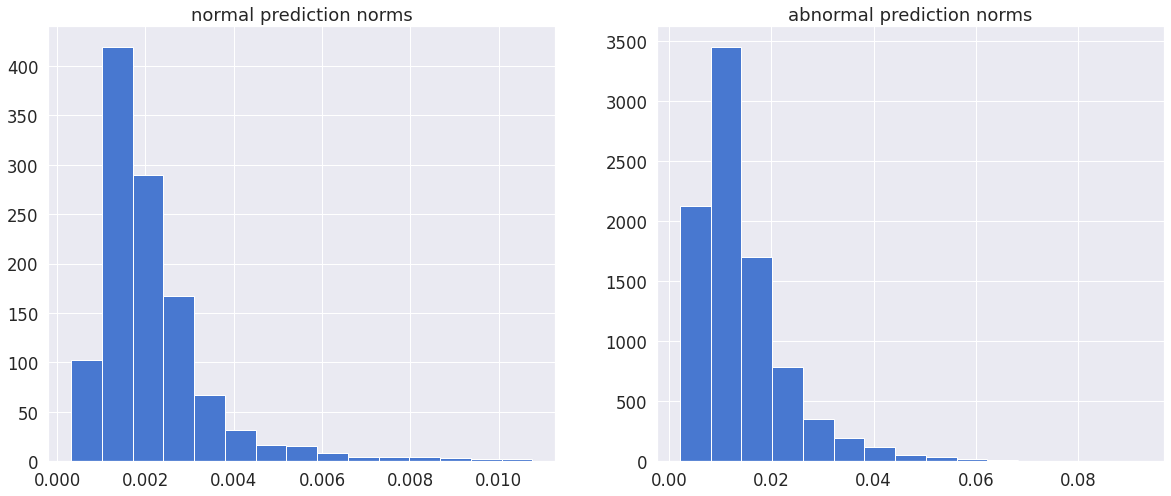

In [31]:
normal_norms, abnormal_norms = [], []

y_scores = svdd.score_samples(x_test)

for score, lab in zip(y_scores, y_test_bin):
    if lab == 0:
        normal_norms.append(score)
    else:
        abnormal_norms.append(score)
        
normal_norms = np.array(normal_norms)
abnormal_norms = np.array(abnormal_norms)

print(y_scores.shape)

fig, axis = plt.subplots(1, 2, figsize=(20, 8))
for ax, n, title in zip(axis.flatten(), [normal_norms, abnormal_norms], ["normal prediction norms", "abnormal prediction norms"]):
    ax.hist(n, bins=15)
    ax.set_title(title)


## Plot ROC

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f02ef6e3b00>)

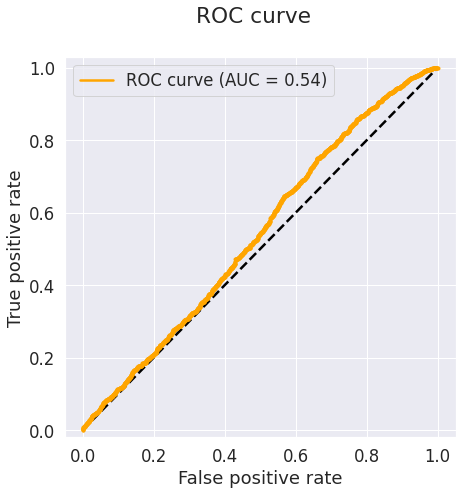

In [44]:
y_scores = svdd.score_samples(x_test)

fprs, tprs, _ = svdd.compute_ROC(y_test_bin, y_scores)

plot_ROC(fprs, tprs)

## t-SNE visualisation

In [ ]:
plot_tSNE(predictions, y_test_bin, plot_center=center, axis=0)

## Evaluate on all classes (AUC score)

In [32]:
n_filters = (8, 4)
dense_shape = 32
LAMBDA = 1e-6

inputs = tf.keras.Input(shape=(28, 28, 1))
c1 = layers.Conv2D(filters=n_filters[0], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                        bias_regularizer=l2(LAMBDA), padding="same", name=f"conv_1")(inputs)
a1 = layers.LeakyReLU(alpha=0.1, name=f"activation_1")(c1)
mp1 = layers.MaxPooling2D((2, 2), name=f"max_pooling_1")(a1)
c2 = layers.Conv2D(filters=n_filters[1], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                        bias_regularizer=l2(LAMBDA), padding="same", name=f"conv_2")(mp1)
a2 = layers.LeakyReLU(alpha=0.1, name=f"activation_2")(c2)
mp2 = layers.MaxPooling2D((2, 2), name=f"max_pooling_2")(a2)
f2 = layers.Flatten()(mp2)
outputs = layers.Dense(dense_shape, kernel_regularizer=l2(LAMBDA), bias_regularizer=l2(LAMBDA))(f2)

m = tf.keras.Model(inputs, outputs)

scores = DeepSVDD.evaluate_on_all(m, digits_train, x_test, y_test_bin, n_classes=10, epochs=50)

Digit 0, # Training examples: 5825
Epoch 1/50
46/46 [==============================] - 0s 7ms/step - total_loss: 6.2240 - centripetal_loss: 6.2240 - weight_decay: 6.4070e-05
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - total_loss: 0.3479 - centripetal_loss: 0.3479 - weight_decay: 6.4421e-05
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - total_loss: 0.2183 - centripetal_loss: 0.2183 - weight_decay: 6.4142e-05
Epoch 4/50
46/46 [==============================] - 0s 6ms/step - total_loss: 0.1695 - centripetal_loss: 0.1695 - weight_decay: 6.3813e-05
Epoch 5/50
46/46 [==============================] - 0s 6ms/step - total_loss: 0.1409 - centripetal_loss: 0.1409 - weight_decay: 6.3488e-05
Epoch 6/50
46/46 [==============================] - 0s 6ms/step - total_loss: 0.1206 - centripetal_loss: 0.1206 - weight_decay: 6.3178e-05
Epoch 7/50
46/46 [==============================] - 0s 6ms/step - total_loss: 0.1047 - centripetal_loss: 0.1047 - weight_decay: 6.2

In [33]:
for i, elt in enumerate(scores):
    print(f"Digit: {i}: AUC = {elt}")

Digit: 0: AUC = 0.47528348626360656
Digit: 1: AUC = 0.9830621336692581
Digit: 2: AUC = 0.5910887492514989
Digit: 3: AUC = 0.5302511236834455
Digit: 4: AUC = 0.7460526100017144
Digit: 5: AUC = 0.7822191909479191
Digit: 6: AUC = 0.7626995236923904
Digit: 7: AUC = 0.9002987047513982
Digit: 8: AUC = 0.9380679850225233
Digit: 9: AUC = 0.9612894842112848


Not the same as Ruff 2018